In [2]:
import torch
from torch import nn
import numpy as np
import torchaudio
import os
from numpy import sort
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Data Cleaning/Creation
## Prepare data to input into our model

In [3]:
def load_audio_data(data_directory, new_sample_rate=8000):
    classes = sort(list(filter(lambda x: x[0] != '.', os.listdir(data_directory))))
    print(classes)
    

    data = []
    labels = []
    for i, c in enumerate(classes):
        for f in os.listdir(data_directory + c):
            try:
                waveform, sample_rate = torchaudio.load(data_directory + c + '/' + f)
                transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
                
                data.append(transform(waveform))
                labels.append(i)
            except:
                continue

    return data, labels, classes

In [4]:
data_directory = 'Data/genres_original/'
data, labels, classes = load_audio_data(data_directory)
# make all the tensors the same size


['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


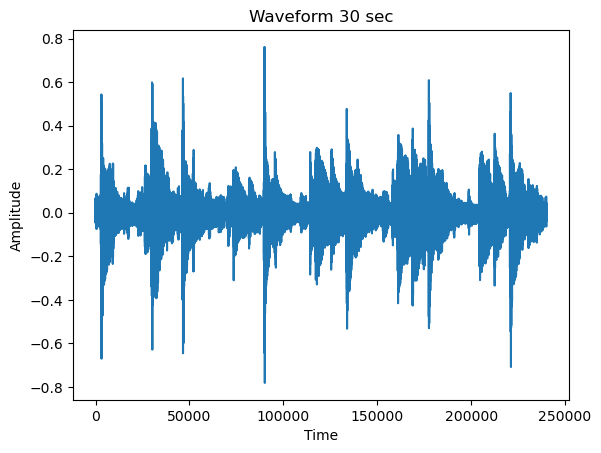

In [5]:
#print waveform 
w = data[0]
plt.figure()
plt.title('Waveform 30 sec')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(w.t().numpy())
plt.show()



In [6]:
# seperate data into training and testing so that there are equal labels in test set

#split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed, stratify=labels)
# make sure every tensor is the same size by padding
max_length = max([x.shape[1] for x in X_train])
X_train = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in X_train]
X_test = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in X_test]



In [7]:
batch_size = 10
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

jazz


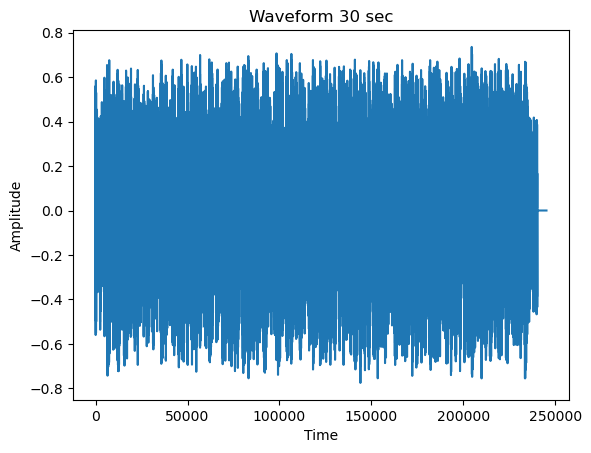

country


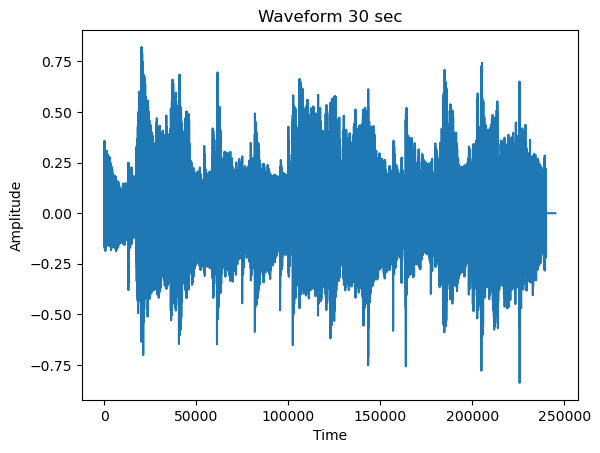

rock


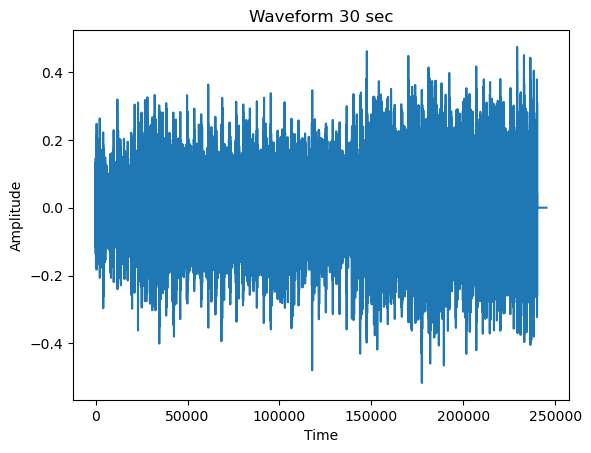

jazz


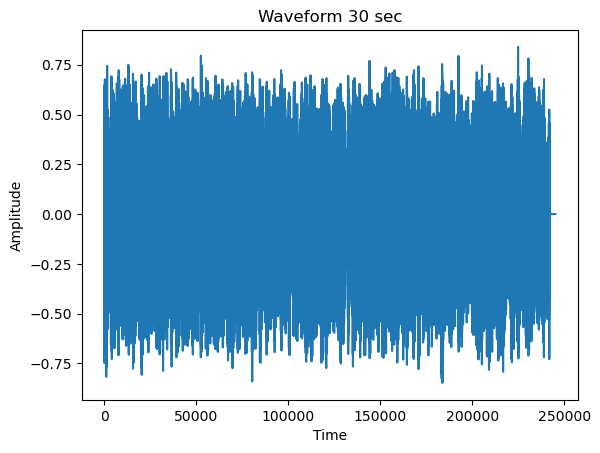

jazz


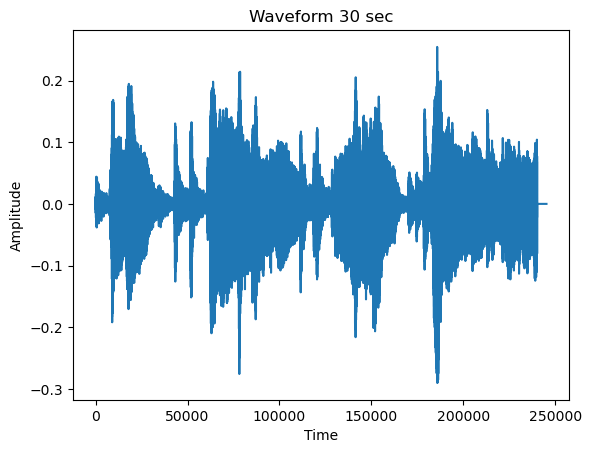

In [8]:
#print tensor with class label
for i in range(5):
    print(classes[y_train[i]])
    plt.figure()
    plt.title('Waveform 30 sec')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.plot(X_train[i].t().numpy())
    plt.show()

In [9]:
# def pad_sequence(batch):
#     # Make all tensor in a batch the same length by padding with zeros
#     batch = [item.t() for item in batch]
#     batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
#     return batch.permute(0, 2, 1)

In [10]:
# def collate_fn(batch):
#     tensors, targets = [], []
#     for waveform, _, label, *_ in batch:
#         tensors += [waveform]
#         targets += [torch.Tensor([labels.index(label)]).squeeze().long()]

#     tensors = pad_sequence(tensors)
#     targets = torch.stack(targets)

#     return tensors, targets

# from torch.utils.data.sampler import SubsetRandomSampler
# batch_size = 64

# train_loader = torch.utils.data.DataLoader(
#     X_train,
#     batch_size=batch_size,
#     collate_fn=collate_fn
# )

# test_loader = torch.utils.data.DataLoader(
#     ,
#     batch_size=batch_size,
#     drop_last=False,
#     collate_fn=collate_fn,
# )

# Creating a Model and Trainging It


In [11]:
class AudioClassificationModel(nn.Module):
    def __init__(self, n_input, n_channel, n_output):
        super().__init__()
        # self.layers = nn.Sequential(
        self.cov = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=16)
        self.batch = nn.BatchNorm1d(n_channel)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.avg = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.lin = nn.Linear(n_channel, n_output)
        # )

    def forward(self, x):
        # return self.layers(x)
        x = self.cov(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.avg(x)
        x = self.flat(x)
        #flip the dimensionality of the tensor
        # print(x.shape)
        # x = torch.transpose(x, 0, 1)
        # print(x.shape)
        x = self.lin(x)
        return x


In [12]:
def train_audio_classification_model(model, train_loader, n_epochs, lr):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(inputs)
           
            loss = criterion(y_pred, labels)
            print("Loss:", loss.item())
            loss.backward()
            optimizer.step()
            
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')
        

def test_audio_classification_model(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for i in range(len(X_test)):
            y_pred = model(X_test[i])
            y_pred = torch.argmax(y_pred).item()
            predictions.append(y_pred)
            print("Predicted: ", classes[y_pred], "Actual: ", classes[y_test[i]])
            if(y_pred == y_test[i]):
                correct += 1

            total += 1
    return correct / total, predictions
        

In [13]:
model = AudioClassificationModel(n_input=1, n_channel=15320, n_output=len(classes))
print(model)



AudioClassificationModel(
  (cov): Conv1d(1, 15320, kernel_size=(80,), stride=(16,))
  (batch): BatchNorm1d(15320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avg): AdaptiveAvgPool1d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=15320, out_features=10, bias=True)
)


In [14]:
model = torch.load('modelSAVED.pt')
for data, label in train_loader:
    print(data.shape)
    print(label.shape)
    print(label)
    outputs = model(data)
    preds = torch.argmax(outputs, dim=1)
    for(pred, label) in zip(preds, label):
        print(classes[pred.item()], classes[label.item()])
    break

torch.Size([10, 1, 245192])
torch.Size([10])
tensor([2, 7, 9, 7, 1, 2, 2, 3, 1, 3])
pop country
pop pop
pop rock
pop pop
blues classical
pop country
pop country
pop disco
classical classical
pop disco


In [15]:
train_audio_classification_model(model, train_loader, n_epochs=1, lr=0.001)

In [ ]:
torch.save(model, 'modelSAVED.pt')

In [ ]:
correct, predictions = test_audio_classification_model(model, X_test, y_test)
def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
plot_confusion_matrix(y_test, predictions, classes)


Predicted:  classical Actual:  classical
Predicted:  country Actual:  blues
Predicted:  country Actual:  metal
Predicted:  blues Actual:  jazz
Predicted:  pop Actual:  blues
Predicted:  country Actual:  country
Predicted:  pop Actual:  rock
Predicted:  jazz Actual:  country
Predicted:  pop Actual:  hiphop
Predicted:  classical Actual:  jazz
Predicted:  pop Actual:  blues
Predicted:  pop Actual:  blues
Predicted:  pop Actual:  reggae
Predicted:  pop Actual:  blues
Predicted:  country Actual:  rock
Predicted:  pop Actual:  disco
Predicted:  disco Actual:  reggae
Predicted:  jazz Actual:  jazz
Predicted:  classical Actual:  disco
Predicted:  country Actual:  rock
Predicted:  classical Actual:  country
Predicted:  country Actual:  metal
Predicted:  blues Actual:  blues
Predicted:  pop Actual:  country
Predicted:  blues Actual:  blues
Predicted:  classical Actual:  classical
Predicted:  classical Actual:  pop
Predicted:  classical Actual:  reggae
Predicted:  classical Actual:  jazz
Predicte

KeyboardInterrupt: 

In [ ]:
def split_audio_clips(data, labels, clip_duration):
    split_data = []
    split_labels = []

    for i, (waveform, sample_rate) in enumerate(data):
        # Calculate the number of samples in each clip
        clip_samples = int(sample_rate * clip_duration)

        # Split the waveform into clips
        for start in range(0, waveform.shape[1], clip_samples):
            end = start + clip_samples
            if end <= waveform.shape[1]:
                clip = waveform[:, start:end]
                split_data.append(clip)
                split_labels.append(labels[i])

    return split_data, split_labels